In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

### Ladda in datasetet

In [2]:
df = pd.read_csv("point to your path")

In [3]:
df['target'].value_counts()

target
disease    1403
healthy    1204
Name: count, dtype: int64

### Dela upp datan i träning och validering

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sickness'], random_state=42)

print("Träningsuppsättning:")
print(train_df['sickness'].value_counts())

print("\nTestuppsättning:")
print(test_df['sickness'].value_counts())

Träningsuppsättning:
sickness
healthy_fish                         963
bacterial_diseases _aeromoniasis     245
fungal_diseases_saprolegniasis       244
bacterial_red disease                231
viral_diseases_white_tail_disease    217
parasitic_diseases                   185
Name: count, dtype: int64

Testuppsättning:
sickness
healthy_fish                         241
fungal_diseases_saprolegniasis        61
bacterial_diseases _aeromoniasis      61
bacterial_red disease                 58
viral_diseases_white_tail_disease     55
parasitic_diseases                    46
Name: count, dtype: int64


### Använd endast om du har augmenterat datan med adding_training_data_and_splittning_dataset.ipynb notebook.

In [51]:
# train_df = df[df['data'] == 'train']
# test_df = df[df['data'] == 'test']

### Följande funktion förbereder bilderna inför träningen, den justerar storleken och gör om det till en array som sedan kan användas i modellen.

In [5]:
def prepare_images(file_paths, target_size=(64, 64)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)


### Vi tränar en CNN modell med flera lager för att kunna extrahera olika funktioner från bilderna

In [6]:
X_train = prepare_images(train_df['path'])
X_test = prepare_images(test_df['path'])

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['target'])
y_test_encoded = label_encoder.transform(test_df['target'])

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)


# Skapa CNN-modell
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Lägg till Dropout-lager
model.add(Dense(2, activation='softmax'))  # Antalet klasser: 2 (sjuk eller inte sjuk)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Träna modellen
model.fit(X_train, y_train_categorical, epochs=30, batch_size=8, validation_split=0.2)




Epoch 1/30


209/209 [==============================] - 2s 6ms/step - loss: 1.8151 - accuracy: 0.5875 - val_loss: 0.6652 - val_accuracy: 0.5755
Epoch 2/30
209/209 [==============================] - 1s 5ms/step - loss: 0.6474 - accuracy: 0.6241 - val_loss: 0.6504 - val_accuracy: 0.6667
Epoch 3/30
209/209 [==============================] - 1s 5ms/step - loss: 0.6567 - accuracy: 0.6175 - val_loss: 0.6283 - val_accuracy: 0.6811
Epoch 4/30
209/209 [==============================] - 1s 5ms/step - loss: 0.6522 - accuracy: 0.6193 - val_loss: 0.6103 - val_accuracy: 0.6547
Epoch 5/30
209/209 [==============================] - 1s 5ms/step - loss: 0.6113 - accuracy: 0.6727 - val_loss: 0.6675 - val_accuracy: 0.5947
Epoch 6/30
209/209 [==============================] - 1s 5ms/step - loss: 0.5931 - accuracy: 0.6930 - val_loss: 0.5918 - val_accuracy: 0.6811
Epoch 7/30
209/209 [==============================] - 1s 5ms/step - loss: 0.5431 - accuracy: 0.7224 - val_loss: 0.5918 - val_accuracy: 0.7074
E

### Vi utvärderar modellen för att se hur bra den presterar på testdatan

17/17 [==============================] - 0s 5ms/step
Accuracy: 0.8122605363984674
              precision    recall  f1-score   support

     disease       0.80      0.87      0.83       281
     healthy       0.83      0.74      0.79       241

    accuracy                           0.81       522
   macro avg       0.82      0.81      0.81       522
weighted avg       0.81      0.81      0.81       522



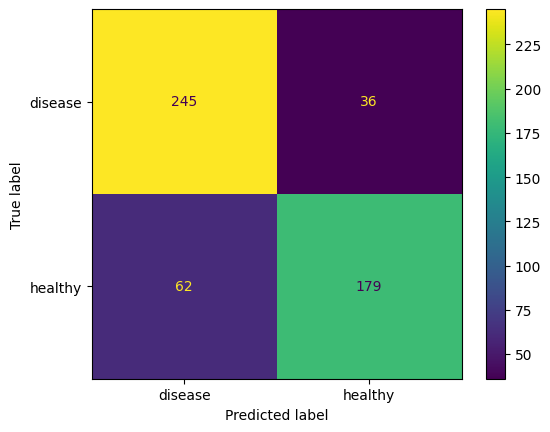

In [7]:
y_pred_categorical = model.predict(X_test)
y_pred = np.argmax(y_pred_categorical, axis=1)

y_test_encoded_inverse = label_encoder.inverse_transform(y_test_encoded)
y_pred_inverse = label_encoder.inverse_transform(y_pred)

class_labels = np.unique(y_test_encoded_inverse)

accuracy = accuracy_score(y_test_encoded_inverse, y_pred_inverse)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test_encoded_inverse, y_pred_inverse))

cm = confusion_matrix(y_test_encoded_inverse, y_pred_inverse, labels=class_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.show()


In [8]:
def random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("Inga bilder hittades i mappen.")
        return None

    random_image = random.choice(image_files)

    img_path = os.path.join(folder_path, random_image)

    return img_path

./dataset/YOLOstacked/images/Healthy_Fish_52.jpg
1/1 [==============================] - 0s 13ms/step
Predicted Class: Diseased
Confidence Score: 0.9277113080024719


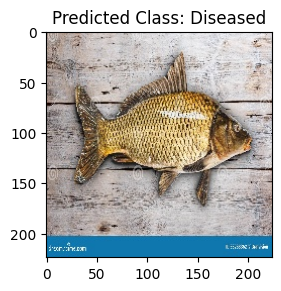

In [9]:
folder_path = './dataset/YOLOstacked/images/'
test_image_path = random_image(folder_path)
print(test_image_path)
test_image = prepare_images([test_image_path])
prediction = model.predict(test_image)

predicted_class_index = np.argmax(prediction[0])
confidence_score = prediction[0][predicted_class_index]

class_labels = ["Diseased", "Healthy"]
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class_label}")
print(f"Confidence Score: {confidence_score}")

original_image = io.imread(test_image_path)

plt.subplot(1, 2, 2)
plt.imshow(original_image)
plt.title(f'Predicted Class: {predicted_class_label}')

plt.show()

In [10]:
test_folder_path = './dataset/test_img/Healthy_fishies/'

# Dictionary för att lagra noggrannheter per undermapp
accuracy_per_class = {}

# Loopa igenom varje undermapp i testmappen
for subdir, dirs, files in os.walk(test_folder_path):
    # Ignorera rotmappen
    if subdir == test_folder_path:
        continue

    # Lista för att lagra sanna klasser och förutsagda klasser för den aktuella undermappen
    true_labels = []
    predicted_labels = []

    for file in files:
        # Skapa den fullständiga sökvägen till varje bild
        img_path = os.path.join(subdir, file)
        test_image = prepare_images([img_path])

        # Gör prediktion med modellen
        prediction = model.predict(test_image)

        # Bestäm sann klass från undermappens namn
        true_class = os.path.basename(subdir)

        # Bestäm förutsagd klass och spara i listor
        predicted_class_index = np.argmax(prediction[0])
        class_labels = ["Diseased", "Healthy"]
        predicted_class_label = class_labels[predicted_class_index]

        true_labels.append('Healthy')
        predicted_labels.append(predicted_class_label)

    # Beräkna noggrannhet för den aktuella undermappen
    accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
    accuracy_per_class[true_class] = accuracy

1/1 [==============================] - 0s 13ms/step


In [11]:
# Skriv ut noggrannhet per undermapp
for class_name, accuracy in accuracy_per_class.items():
    print(f"Noggrannhet för {class_name}: {accuracy * 100:.2f}%")

Noggrannhet för Black Sea Sprat: 25.00%
Noggrannhet för Gilt-Head Bream: 48.08%
Noggrannhet för Hourse Mackerel: 38.64%
Noggrannhet för Red Mullet: 25.00%
Noggrannhet för Red Sea Bream: 19.57%
Noggrannhet för Sea Bass: 44.74%
Noggrannhet för Striped Red Mullet: 20.00%


In [12]:
model.save('point to path for saving the model')

c:\Kodprojekt\sick_fishes\env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# loaded_model = load_model('./saved_models/cnn_model_original_data_10-1-24.h5')